### Colab Setup

In [ ]:
!unzip /content/pretrained_models.zip


In [ ]:
% cd /content/pretrained_models/tensorflow

/content/pretrained_models/tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
savePath = "/content/drive/MyDrive/MinervaModel/"

### Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
# from tensorboard.plugins.hparams import api as hp
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
# from tensorflow.python.keras import backend as K


### Parameters

In [ ]:
batch_size = 64
img_height = 150
img_width = 150
data_dir = "../data/" 

### Get Training Data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+"train/",
  labels="inferred",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26795 files belonging to 2 classes.
Using 21436 files for training.


### Get Validation Data

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+"train/",
  labels="inferred",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26795 files belonging to 2 classes.
Using 5359 files for validation.


### Get Testing Data

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+"test/",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7536 files belonging to 2 classes.


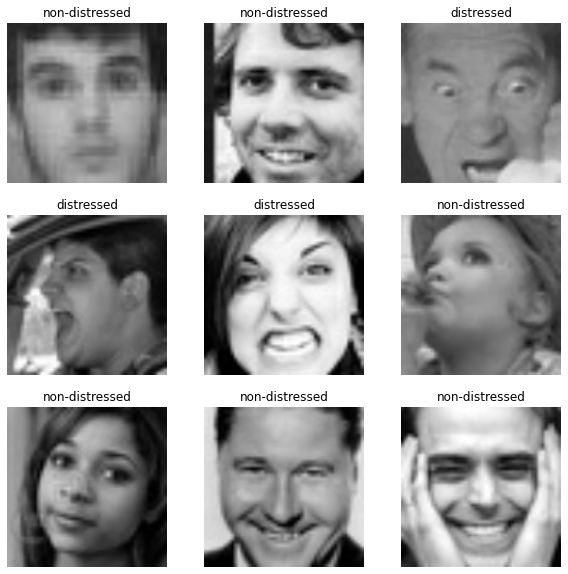

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im = images[i].numpy().astype("uint8")
    plt.imshow(im)
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Load Pretrained Model

In [ ]:
def getBaseModel():
  base_model = keras.applications.Xception(
      weights='imagenet',  # Load weights pre-trained on ImageNet.
      input_shape=(150, 150, 3),
      include_top=False)  # Do not include the ImageNet classifier at the top.
  return base_model

### Setting Up Model


In [ ]:
def setupModel(baseModel, name):
  inputs = keras.Input(shape=(img_height, img_width, 3))

  x = baseModel(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.GlobalAveragePooling2D()(x)
  # A Dense classifier with a single unit (binary classification)
  # outputs = keras.layers.Dense(1)(x)
  outputs = keras.activations.sigmoid(keras.layers.Dense(1)(x))
  model = keras.Model(inputs, outputs)
  return model

### Freezed Training

In [ ]:
def freezedTraining(model, baseModel, optimizers, numEpochs, loss):
    # freeze the base layer weights
    baseModel.trainable = False
    model.compile(optimizer=optimizers,
                loss=loss,
                metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
    print(model.summary())
    earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    history = model.fit(train_ds, epochs=numEpochs, validation_data=val_ds, callbacks=[earlyStopping])
    return history

### Unfreeze Training

In [ ]:
def unfreezedTraining(model, baseModel, optimizer, numEpochs, modelName, loss):
      # Unfreeze the base model
      baseModel.trainable = True
      # with K.name_scope(model.optimizer.__class__.__name__):
      #       for i, var in enumerate(model.optimizer.weights):
      #           name = 'variable{}'.format(i)
      #           model.optimizer.weights[i] = tf.Variable(var, name=name)
      earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
      # mcp_save = ModelCheckpoint(modelName, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
      reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min')

      model.compile(optimizer=optimizer,  # Very low learning rate
                    loss=loss,
                    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
      print(model.summary())

      history = model.fit(train_ds, epochs=numEpochs, validation_data=val_ds, callbacks=[earlyStopping, reduce_lr_loss])
      return history

### Hyperparameter Optimization

In [ ]:
fineTuneLR = 1e-5
lossFunctions = [(keras.losses.BinaryCrossentropy(), 'BinaryCrossEntropy')]
optimizers = [
                (keras.optimizers.Adam(), keras.optimizers.Adam(learning_rate=fineTuneLR), 'Adams'), 
                (keras.optimizers.SGD(), keras.optimizers.SGD(learning_rate=fineTuneLR), 'SGD'),
                (keras.optimizers.RMSprop(), keras.optimizers.RMSprop(learning_rate=fineTuneLR), 'RMSprop')
             ]
modelName = 'ImageNetXception'

In [ ]:
resultsForGraph =  {}
for lossFunc, lossName in lossFunctions:
    for freezeOptimizer, unfreezeOptimizer, optimizerName in optimizers:
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        print("####################Loss: " + lossName + " Optimizer: " + optimizerName + "####################")
        print("--------------------Get Pretrained Model--------------------")
        base_model = getBaseModel()
        print("--------------------Setup Model--------------------")
        model = setupModel(base_model, modelName+lossName+optimizerName)

        print("--------------------Freezed Training--------------------")
        history = freezedTraining(model, base_model, freezeOptimizer,  100, lossFunc)
        acc = history.history['binary_accuracy']
        val_acc = history.history['val_binary_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        print("--------------------Fine Tunning--------------------")
        history_fine = unfreezedTraining(model, base_model, unfreezeOptimizer, 100, modelName+lossName+optimizerName+'.h5', lossFunc)
        acc += history_fine.history['binary_accuracy']
        val_acc += history_fine.history['val_binary_accuracy']

        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

        print("--------------------Testing Result--------------------")
        results = model.evaluate(test_ds, batch_size=batch_size)
        resultsForGraph[modelName+lossName+optimizerName] = (acc, loss, val_acc, val_loss, results)
        print("--------------------Saving Model--------------------")
        print("saving model to: "+savePath+modelName+lossName+optimizerName) 
        model.save(savePath+modelName+lossName+optimizerName, save_format='h5')



####################Loss: BinaryCrossEntropy Optimizer: Adams####################
--------------------Get Pretrained Model--------------------
83689472/83683744 [==============================] - 6s 0us/step
--------------------Setup Model--------------------
--------------------Freezed Training--------------------
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
_________________________________________________________________
t

### Visualization

In [ ]:
import pickle
f = open(savePath+"ImageNetXceptionResultDic.pkl","wb")
pickle.dump(resultsForGraph,f)
f.close()

In [ ]:
epochs = {
            "ImageNetXceptionBinaryCrossEntropyAdams": (13, 8), 
            "ImageNetXceptionBinaryCrossEntropySGD": (8, 14),
            "ImageNetXceptionBinaryCrossEntropyRMSprop": (6, 31)
          }

Accuracy: 0.7192144393920898 Recall: 0.7031992673873901 Precision: 0.6531332731246948


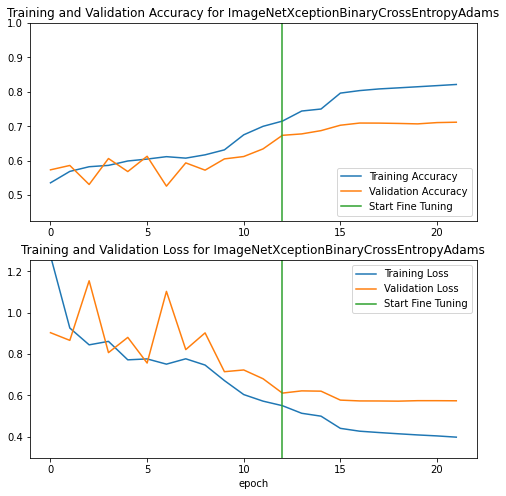

Accuracy: 0.6015127301216125 Recall: 0.5612923502922058 Precision: 0.522713840007782


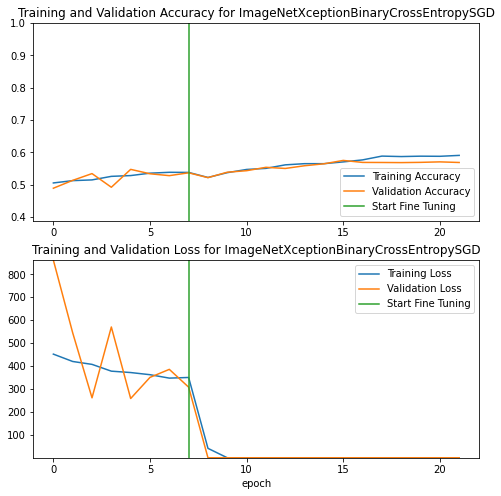

Accuracy: 0.7237260937690735 Recall: 0.7079505920410156 Precision: 0.6583210825920105


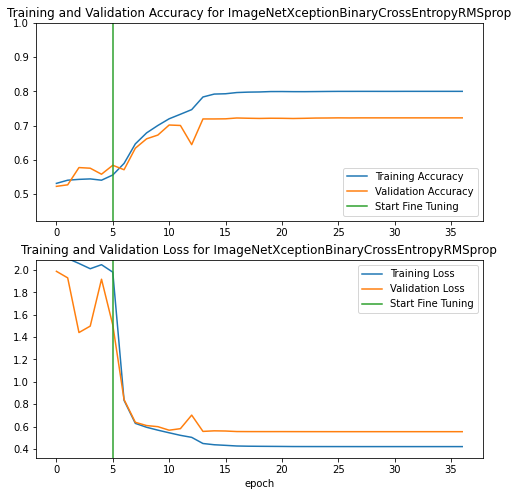

In [ ]:
for name, v in resultsForGraph.items():
    acc, loss, val_acc, val_loss, result = v
    print("Accuracy: "+str(result[1])+ " Recall: "+str(result[2])+" Precision: "+str(result[3]))
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([min(val_acc)-.1, 1.0])
    initial_epochs = epochs[name][0]
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy for '+ name)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([min(loss)-.1, max(val_loss)+.1])
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss for '+name)
    plt.xlabel('epoch')
    plt.show()